# Bayesian Multiobjective Optimization
*Joachim van der Herten, Ivo Couckuyt*

This notebook demonstrates the multiobjective optimization of an analytical function using the hypervolume-based probability of improvement function.

In [1]:
%matplotlib inline
from matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt

import GPflow
import GPflowOpt
import numpy as np

First we set up an objective function (the Veldhuizen and Lamont multiobjective optimization problem 2 [vlmop2]). The vlmop2 function is a very easy problem. Ideal for illustrating Bayesian multiobjective optimization.

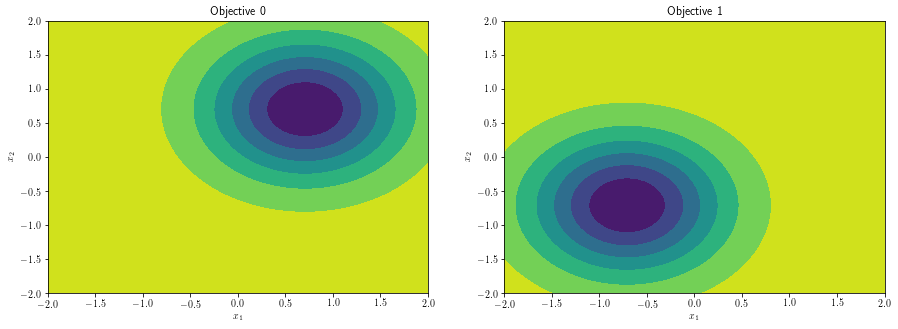

In [2]:
# Objective
def vlmop2(x):
    transl = 1 / np.sqrt(2)
    part1 = (x[:, [0]] - transl) ** 2 + (x[:, [1]] - transl) ** 2
    part2 = (x[:, [0]] + transl) ** 2 + (x[:, [1]] + transl) ** 2
    y1 = 1 - np.exp(-1 * part1)
    y2 = 1 - np.exp(-1 * part2)
    return np.hstack((y1, y2))

# Setup input domain
domain = GPflowOpt.domain.ContinuousParameter('x1', -2, 2) + \
         GPflowOpt.domain.ContinuousParameter('x2', -2, 2)

# Plot
def plotfx():  
    X = GPflowOpt.design.FactorialDesign(101, domain).generate()
    Z = vlmop2(X)
    shape = (101, 101)
    
    axes = []
    plt.figure(figsize=(15, 5))
    for i in range(Z.shape[1]):
        axes = axes + [plt.subplot2grid((1, 2), (0, i))]

        axes[-1].contourf(X[:,0].reshape(shape), X[:,1].reshape(shape), Z[:,i].reshape(shape))
        axes[-1].set_title('Objective {}'.format(i))
        axes[-1].set_xlabel('$x_1$')
        axes[-1].set_ylabel('$x_2$')
        axes[-1].set_xlim([domain.lower[0], domain.upper[0]])
        axes[-1].set_ylim([domain.lower[1], domain.upper[1]])
    
    return axes

plotfx();

We can model the belief of each objective by one GP prior or model each objective separately using a GP prior. One GP prior is suitable when the it is expected that the correlation of the inputs of the objectives are somewhat similar, otherwise a separate GP prior is preferred. We illustrate both approaches here.

Both functions are evaluated on a space-filling set of points (here, a Latin Hypercube design). In total three GPR models are created.

The hypervolume-based probability of improvement is based on the model(s) of the objective functions (vlmop2) and aggregates all the information in one cost function which favors points improving or augmenting the Pareto front. In multiobjective optimization the definition of improvement is ambigious. Here we define improvement using the contributing hypervolume and it determines the density and uniformity of the identified Pareto front.

In [3]:
# Initial evaluations
design = GPflowOpt.design.LatinHyperCube(11, domain)
X = design.generate()
Y = vlmop2(X)

# Approach 1: one model for both objectives
objective_model = GPflow.gpr.GPR(X.copy(), Y.copy(), GPflow.kernels.Matern52(2, ARD=True))
objective_model.likelihood.variance = 0.01

hvpoi_1 = GPflowOpt.acquisition.HVProbabilityOfImprovement(objective_model)

# Approach 2: one model for each objective
objective_models = [GPflow.gpr.GPR(X.copy(), Y[:,[i]].copy(), GPflow.kernels.Matern52(2, ARD=True)) for i in range(Y.shape[1])]
for model in objective_models:
    model.likelihood.variance = 0.01

hvpoi_2 = GPflowOpt.acquisition.HVProbabilityOfImprovement(objective_models)

hvpoi = [hvpoi_1, hvpoi_2]

Running the Bayesian optimization is the next step. For this, we must set up an appropriate strategy to optimize the multiobjective acquisition function. Sometimes this can be a bit challenging as often large non-varying areas may occur. A typical strategy is to apply a Monte Carlo optimization step first, then optimize the point with the best value (several variations exist). This approach is followed here. We then run the Bayesian Optimization and allow it to select up to 20 additional decisions. 

The multiobjective acquisition function balances between improving on the current best Pareto front, augmenting the Pareto front to make it more dense, and improving our belief of the objectives.

In [4]:
# First setup the optimization strategy for the acquisition function
# Combining MC step followed by L-BFGS-B
acquisition_opt = GPflowOpt.optim.StagedOptimizer([GPflowOpt.optim.MCOptimizer(domain, 200), 
                                                   GPflowOpt.optim.SciPyOptimizer(domain)])

# Then run the BayesianOptimizer for 20 iterations
for acq in hvpoi:
    optimizer = GPflowOpt.BayesianOptimizer(domain, acq, optimizer=acquisition_opt)
    with optimizer.silent():
        result = optimizer.optimize([vlmop2], n_iter=20)

    print(result)

     fun: array([[ 0.98935582,  0.01711023],
       [ 0.88278039,  0.30030945],
       [ 0.72867413,  0.55802535],
       [ 0.53223184,  0.72719495],
       [ 0.76641374,  0.48183658],
       [ 0.1490411 ,  0.92765938],
       [ 0.42841247,  0.79150683],
       [ 0.02708456,  0.97659865],
       [ 0.63212056,  0.63212056],
       [ 0.94169528,  0.09499044],
       [ 0.3625705 ,  0.83326738],
       [ 0.8913401 ,  0.2366022 ],
       [ 0.3304642 ,  0.84567979],
       [ 0.91630559,  0.17492364],
       [ 0.82441613,  0.38382657],
       [ 0.69321344,  0.56797478],
       [ 0.24802641,  0.88925288],
       [ 0.95830141,  0.05092243],
       [ 0.56711559,  0.71205582],
       [ 0.80096189,  0.41471879],
       [ 0.8495463 ,  0.32233939]])
 message: 'OK'
    nfev: 20
 success: True
       x: array([[-0.8       , -0.8       ],
       [-0.15626879, -0.47538579],
       [ 0.06472327, -0.23723326],
       [ 0.02042715,  0.17021426],
       [-0.23073274, -0.05095712],
       [ 0.35171742,  0.51

For multiple objective functions the returned `OptimizeResult` object contains the Pareto front. When plotting the belief, we clearly see that for vlmop2 both approaches perform similarly. This is because vlmop2 is a very easy function where each objective has the same correlation properties. In this case one GP prior might even be a benefit. However, for many real-life multiobjective optimization problems a separate GP prior for each objective is best.

name.kern.lengthscales transform:+ve prior:None
[ 0.57520586  0.60203243]
name.kern.variance transform:+ve prior:None
[ 4.13533454]
name.likelihood.variance transform:+ve prior:None
[  1.00000014e-06]

name.kern.lengthscales transform:+ve prior:None
[ 0.58694716  0.5785026 ]
name.kern.variance transform:+ve prior:None
[ 4.34881228]
name.likelihood.variance transform:+ve prior:None
[  1.00000016e-06]

name.kern.lengthscales transform:+ve prior:None
[ 0.59574858  0.59673654]
name.kern.variance transform:+ve prior:None
[ 3.33847522]
name.likelihood.variance transform:+ve prior:None
[  1.00000008e-06]



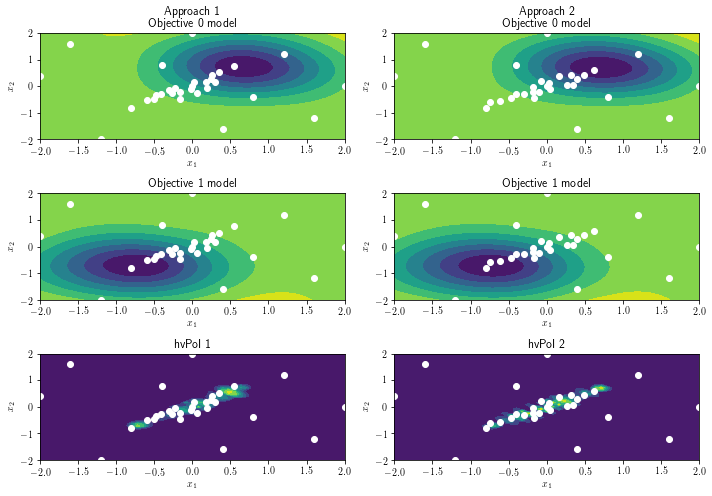

In [5]:
def plot():
    grid_size = 51  # 101
    shape = (grid_size, grid_size)
    
    Xeval = GPflowOpt.design.FactorialDesign(grid_size, domain).generate()
    
    Yeval_1, _ = hvpoi[0].models[0].predict_f(Xeval)
    Yeval_21, _ = hvpoi[1].models[0].predict_f(Xeval)
    Yeval_22, _ = hvpoi[1].models[1].predict_f(Xeval)
            
    Yevalc_1 = hvpoi[0].evaluate(Xeval)
    Yevalc_2 = hvpoi[1].evaluate(Xeval)
    
    plots = [('Approach 1\nObjective 0 model', Yeval_1[:,0]),
             ('Objective 1 model', Yeval_1[:,1]),
             ('hvPoI 1', Yevalc_1),
             ('Approach 2\nObjective 0 model', Yeval_21[:,0]),
             ('Objective 1 model', Yeval_22[:,0]),
             ('hvPoI 2', Yevalc_2)]

    plt.figure(figsize=(10,7))
    for i, plot in enumerate(plots):
        if i > 2:
            ax = plt.subplot2grid((3, 2), (i-3, 1))
            data = hvpoi[1].data[0]
        else:
            ax = plt.subplot2grid((3, 2), (i, 0))
            data = hvpoi[0].data[0]
            
        ax.contourf(Xeval[:,0].reshape(shape), Xeval[:,1].reshape(shape), plot[1].reshape(shape))
        ax.scatter(data[:,0], data[:,1], c='w')
        ax.set_title(plot[0])
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.set_xlim([domain.lower[0], domain.upper[0]])
        ax.set_ylim([domain.lower[1], domain.upper[1]])
    plt.tight_layout()
    
# Plot representing the model belief, and the belief mapped to EI and PoF
plot()

print(objective_model)
for model in objective_models:
    print(model)

Finally, we can extract and plot the Pareto front ourselves using the `non_dominated_sort` function of the `pareto` class. It returns a set of indices that sorts the points based first on their dominance (the number of points that it is dominated by) and secondly on the distance to neighbouring points.
For example, to plot the Pareto front we could only select the points with dom == 0 (the non-dominated points). Here we choose to use the dominance vector to color the points.

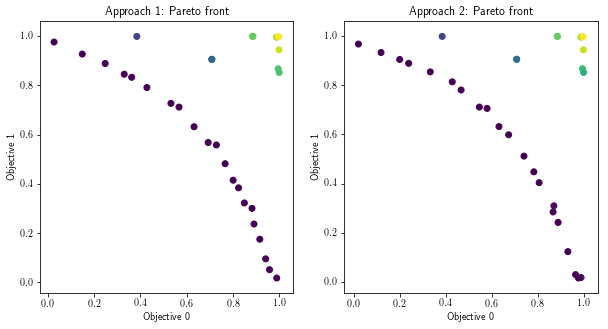

In [6]:
# plot pareto front
plt.figure(figsize=(10, 5))

for i, acq in enumerate(hvpoi):
    ax = plt.subplot2grid((1, 2), (0, i))

    idx, dom, _ = GPflowOpt.pareto.non_dominated_sort(acq.data[1])

    ax.scatter(acq.data[1][:,0], acq.data[1][:,1], c=dom)
    ax.set_title('Approach {}: Pareto front'.format(i+1))
    ax.set_xlabel('Objective 0')
    ax.set_ylabel('Objective 1')
